# Sequence Explorer

In [1]:
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

images_dir = Path('images')
masks_dir = Path('masks')

selected_seq = 'ns050a'
sequence_images = sorted([p for p in images_dir.glob(f"{selected_seq}*.png")])
sequence_masks = [masks_dir / p.name for p in sequence_images]
print(f'Total frames loaded: {len(sequence_images)}')

Total frames loaded: 97


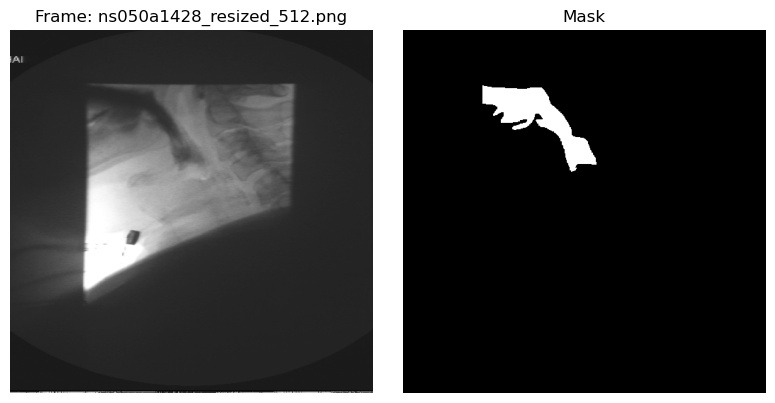

In [3]:
frame_index = 3
frame_path = sequence_images[frame_index]
mask_path = sequence_masks[frame_index]
frame = cv2.imread(str(frame_path), cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE) if mask_path.exists() else None

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(frame, cmap='gray')
axs[0].set_title(f'Frame: {frame_path.name}')
axs[0].axis('off')
axs[1].imshow(mask, cmap='gray' if mask is not None else 'gray')
axs[1].set_title('Mask' if mask is not None else 'Mask not found')
axs[1].axis('off')
plt.tight_layout()
plt.show()

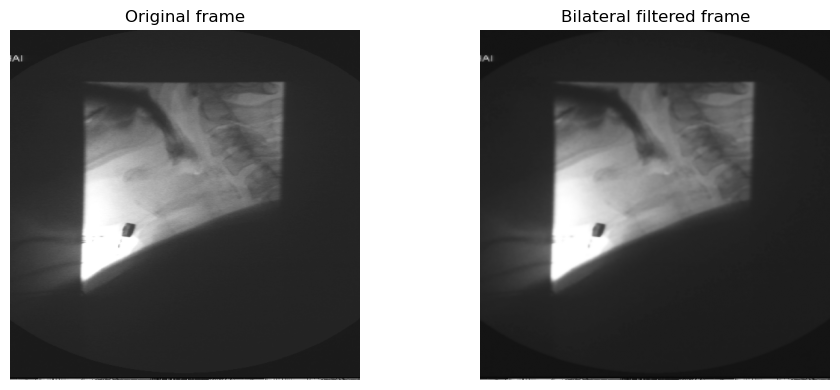

In [4]:
# Apply bilateral filter to the selected frame
if 'frame' not in globals():
    raise RuntimeError('Run the previous cell first to load a frame.')
filtered = cv2.bilateralFilter(frame, d=5, sigmaColor=75, sigmaSpace=75)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(frame, cmap='gray')
axs[0].set_title('Original frame')
axs[0].axis('off')
axs[1].imshow(filtered, cmap='gray')
axs[1].set_title('Bilateral filtered frame')
axs[1].axis('off')
plt.tight_layout()
plt.show()

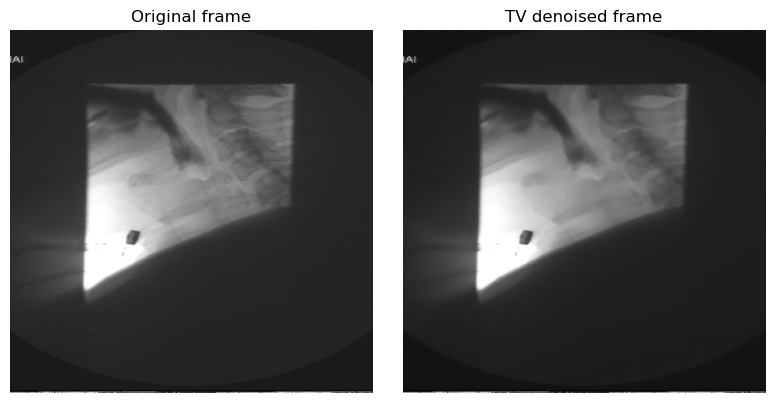

In [5]:
# Apply TV denoising to the selected frame
if 'frame' not in globals():
    raise RuntimeError('Run the frame loading cell first.')
from skimage.restoration import denoise_tv_chambolle
tv_denoised = denoise_tv_chambolle(frame.astype(float) / 255.0, weight=0.02)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(frame, cmap='gray')
axs[0].set_title('Original frame')
axs[0].axis('off')
axs[1].imshow(tv_denoised, cmap='gray')
axs[1].set_title('TV denoised frame')
axs[1].axis('off')
plt.tight_layout()
plt.show()

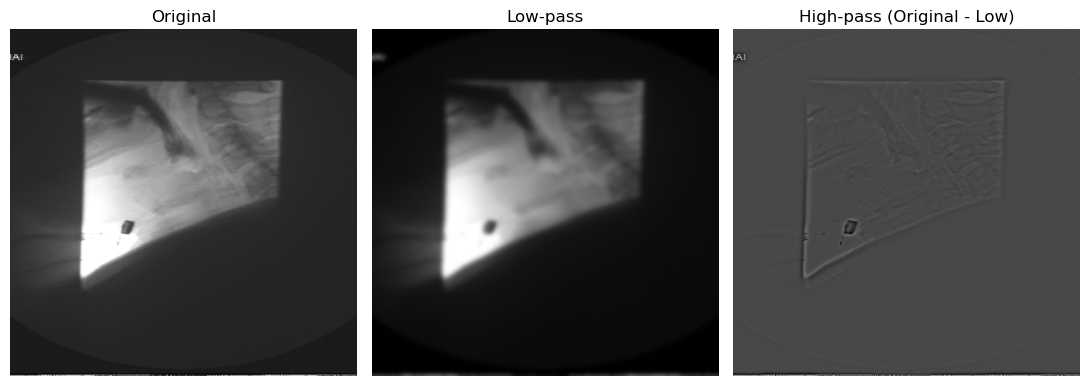

In [6]:
# Apply simple low-pass and high-pass filters to the selected frame
if 'frame' not in globals():
    raise RuntimeError('Run the frame loading cell first.')
import numpy as np
from scipy.ndimage import gaussian_filter

frame_float = frame.astype(np.float32)
low_pass = gaussian_filter(frame_float, sigma=3)
high_pass = frame_float - low_pass

fig, axs = plt.subplots(1, 3, figsize=(11, 4))
axs[0].imshow(frame, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(low_pass, cmap='gray')
axs[1].set_title('Low-pass')
axs[1].axis('off')
axs[2].imshow(high_pass, cmap='gray')
axs[2].set_title('High-pass (Original - Low)')
axs[2].axis('off')
plt.tight_layout()
plt.show()

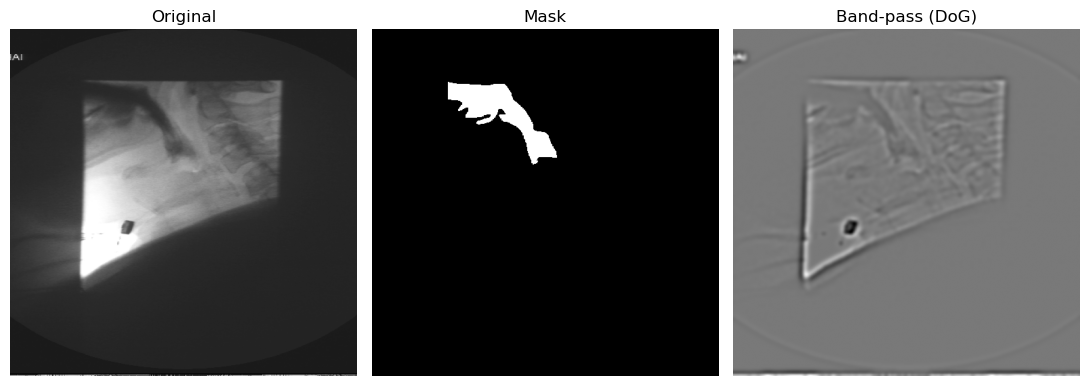

In [7]:
# Apply band-pass filter (difference of Gaussians)
if 'frame' not in globals():
    raise RuntimeError('Run the frame loading cell first.')
from scipy.ndimage import gaussian_filter

frame_float = frame.astype(float)
low_sigma, high_sigma = 3, 4
low_blur = gaussian_filter(frame_float, sigma=low_sigma)
high_blur = gaussian_filter(frame_float, sigma=high_sigma)
band_pass = low_blur - high_blur

fig, axs = plt.subplots(1, 3, figsize=(11, 4))
axs[0].imshow(frame, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(mask, cmap='gray' if mask is not None else 'gray')
axs[1].set_title('Mask' if mask is not None else 'Mask not found')
axs[1].axis('off')
axs[2].imshow(band_pass, cmap='gray')
axs[2].set_title('Band-pass (DoG)')
axs[2].axis('off')
plt.tight_layout()
plt.show()

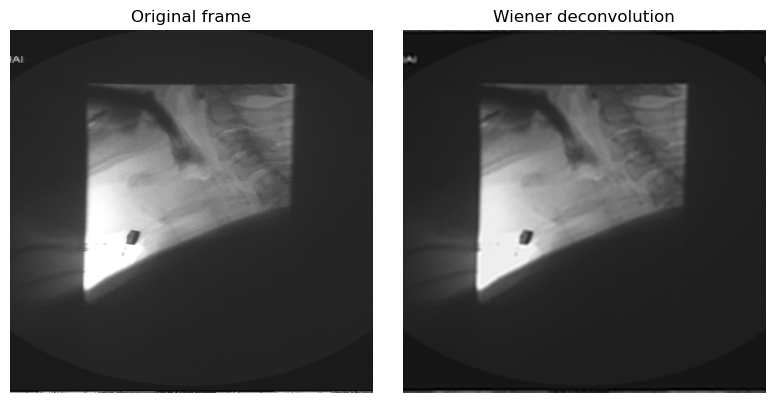

In [8]:
# Apply Wiener deconvolution with a simple PSF
if 'frame' not in globals():
    raise RuntimeError('Run the frame loading cell first.')
from skimage.restoration import wiener
import numpy as np

frame_float = frame.astype(np.float32) / 255.0
psf_size = 5
psf = np.ones((psf_size, psf_size), dtype=np.float32) / (psf_size ** 2)
result = wiener(frame_float, psf, balance=1, clip=False)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(frame, cmap='gray')
axs[0].set_title('Original frame')
axs[0].axis('off')
axs[1].imshow(result, cmap='gray')
axs[1].set_title('Wiener deconvolution')
axs[1].axis('off')
plt.tight_layout()
plt.show()

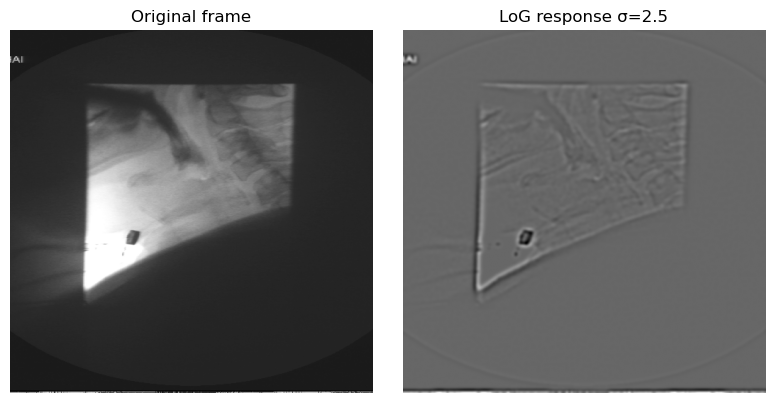

In [9]:
# Gaussian-Laplace edge detection
if 'frame' not in globals():
    raise RuntimeError('Run the frame loading cell first.')
from scipy.ndimage import gaussian_laplace

sigma = 2.5
edges = -gaussian_laplace(frame.astype(float), sigma=sigma)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(frame, cmap='gray')
axs[0].set_title('Original frame')
axs[0].axis('off')
axs[1].imshow(edges, cmap='gray')
axs[1].set_title(f'LoG response σ={sigma}')
axs[1].axis('off')
plt.tight_layout()
plt.show()

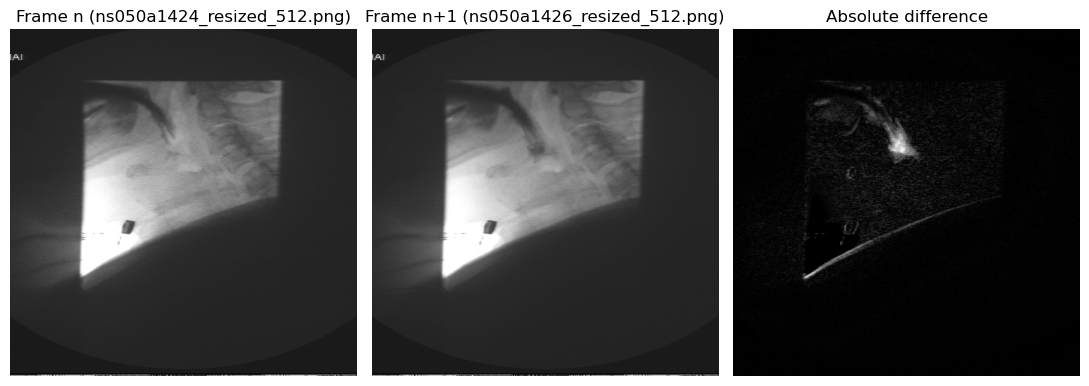

In [10]:
n = 1
frame_n = cv2.imread(str(sequence_images[n]), cv2.IMREAD_GRAYSCALE)
frame_np1 = cv2.imread(str(sequence_images[n + 1]), cv2.IMREAD_GRAYSCALE)
if frame_n is None or frame_np1 is None:
    raise FileNotFoundError('Could not load one of the frames.')

diff = cv2.absdiff(frame_n, frame_np1)

fig, axs = plt.subplots(1, 3, figsize=(11, 4))
axs[0].imshow(frame_n, cmap='gray')
axs[0].set_title(f'Frame n ({sequence_images[n].name})')
axs[0].axis('off')
axs[1].imshow(frame_np1, cmap='gray')
axs[1].set_title(f'Frame n+1 ({sequence_images[n + 1].name})')
axs[1].axis('off')
axs[2].imshow(diff, cmap='gray')
axs[2].set_title('Absolute difference')
axs[2].axis('off')
plt.tight_layout()
plt.show()

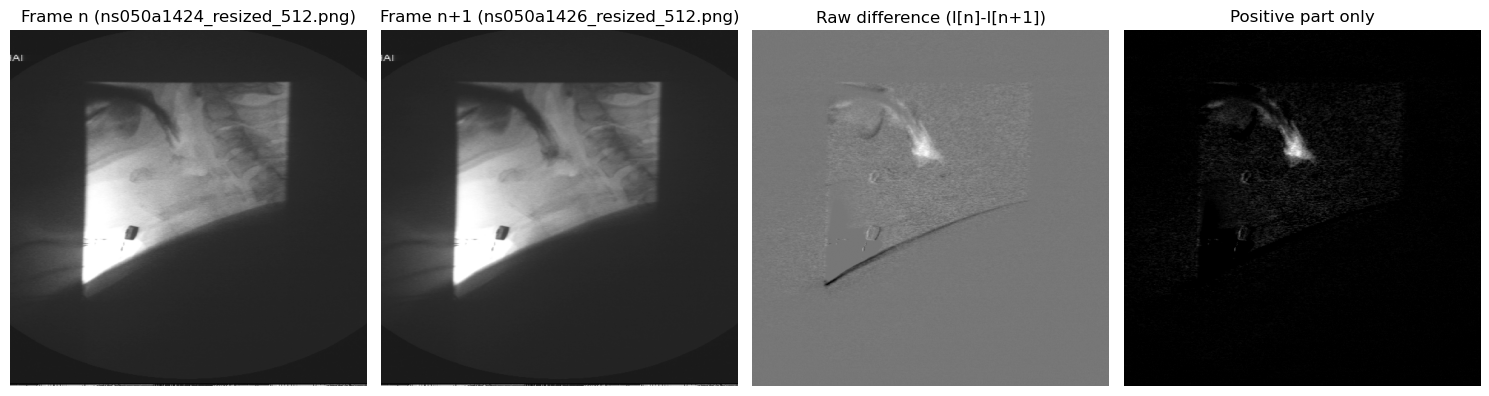

In [11]:
n = 1
frame_n = cv2.imread(str(sequence_images[n]), cv2.IMREAD_GRAYSCALE).astype(np.float32)
frame_np1 = cv2.imread(str(sequence_images[n + 1]), cv2.IMREAD_GRAYSCALE).astype(np.float32)
if frame_n is None or frame_np1 is None:
    raise FileNotFoundError('Could not load one of the frames.')

diff = frame_n - frame_np1
positive_diff = np.maximum(diff, 0)

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
axs[0].imshow(frame_n, cmap='gray')
axs[0].set_title(f'Frame n ({sequence_images[n].name})')
axs[0].axis('off')
axs[1].imshow(frame_np1, cmap='gray')
axs[1].set_title(f'Frame n+1 ({sequence_images[n + 1].name})')
axs[1].axis('off')
axs[2].imshow(diff, cmap='gray')
axs[2].set_title('Raw difference (I[n]-I[n+1])')
axs[2].axis('off')
axs[3].imshow(positive_diff, cmap='gray')
axs[3].set_title('Positive part only')
axs[3].axis('off')
plt.tight_layout()
plt.show()

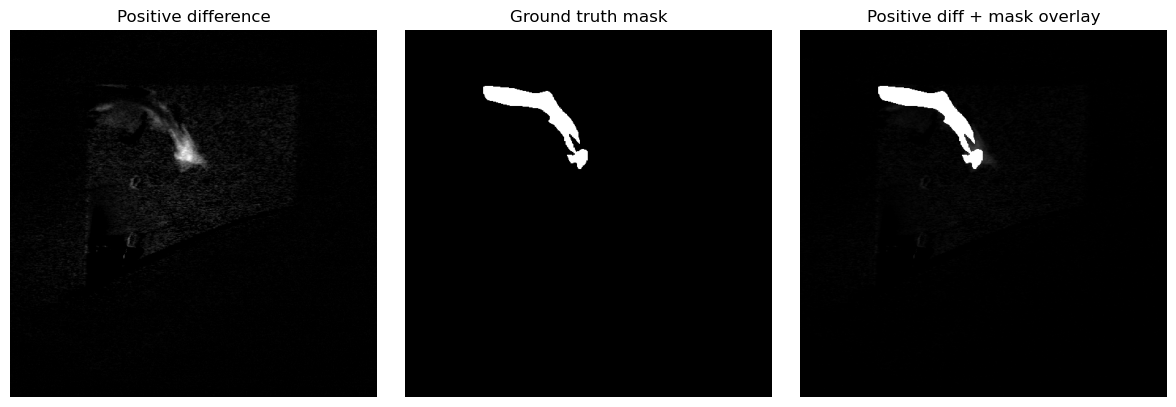

In [12]:
mask_path = sequence_masks[n]
mask_n = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
if mask_n is None:
    raise FileNotFoundError(f'No mask found for {sequence_images[n].name}')

overlay = positive_diff.copy()
overlay[mask_n > 0] = np.minimum(overlay[mask_n > 0] + 255, 255)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(positive_diff, cmap='gray')
axs[0].set_title('Positive difference')
axs[0].axis('off')
axs[1].imshow(mask_n, cmap='gray')
axs[1].set_title('Ground truth mask')
axs[1].axis('off')
axs[2].imshow(overlay, cmap='gray')
axs[2].set_title('Positive diff + mask overlay')
axs[2].axis('off')
plt.tight_layout()
plt.show()

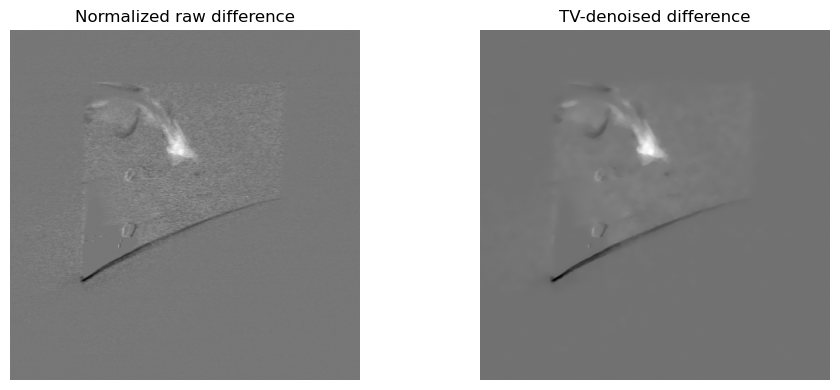

In [13]:
# TV denoise the previously computed raw difference
if 'diff' not in globals():
    raise RuntimeError('Run the raw difference cell first to create `diff`.')
from skimage.restoration import denoise_tv_chambolle

diff_norm = (diff - diff.min())/(diff.max() - diff.min() + 1e-6)
tv_diff = denoise_tv_chambolle(diff_norm, weight=0.05)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(diff_norm, cmap='gray')
axs[0].set_title('Normalized raw difference')
axs[0].axis('off')
axs[1].imshow(tv_diff, cmap='gray')
axs[1].set_title('TV-denoised difference')
axs[1].axis('off')
plt.tight_layout()
plt.show()

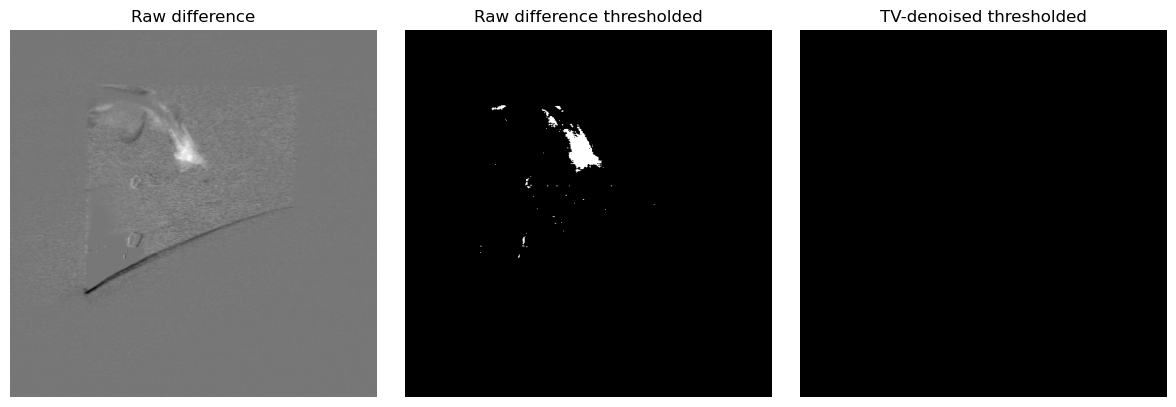

In [14]:
# Threshold raw and TV-denoised difference into binary maps
if 'diff' not in globals():
    raise RuntimeError('Run the raw difference cell first to create `diff`.')
if 'tv_diff' not in globals():
    raise RuntimeError('Run the TV-denoise difference cell first to create `tv_diff`.')

diff_binary = (diff > 18).astype(np.uint8) * 255
tv_binary = (tv_diff > -3).astype(np.uint8) * 255

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(diff, cmap='gray')
axs[0].set_title('Raw difference')
axs[0].axis('off')
axs[1].imshow(diff_binary, cmap='gray')
axs[1].set_title('Raw difference thresholded')
axs[1].axis('off')
axs[2].imshow(tv_binary, cmap='gray')
axs[2].set_title('TV-denoised thresholded')
axs[2].axis('off')
plt.tight_layout()
plt.show()

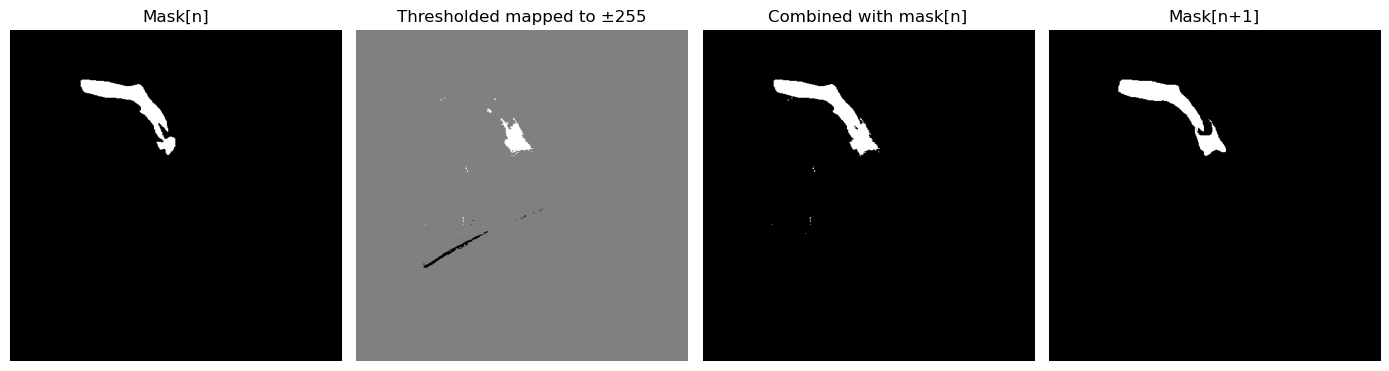

In [15]:
# Threshold raw diff (|pixel|>18), map to ±255, combine with mask[n]
if 'diff' not in globals() or 'n' not in globals():
    raise RuntimeError('Run the raw difference cell first to define `diff` and `n`.')
threshold = 25
mask_n = cv2.imread(str(sequence_masks[n]), cv2.IMREAD_GRAYSCALE)
if mask_n is None:
    raise FileNotFoundError(f'Mask for frame n ({sequence_images[n].name}) not found.')
mask_np1 = cv2.imread(str(sequence_masks[n + 1]), cv2.IMREAD_GRAYSCALE)
if mask_np1 is None:
    raise FileNotFoundError(f'Mask for frame n+1 ({sequence_images[n + 1].name}) not found.')

mask = np.abs(diff) > threshold
thresholded = np.where(mask, diff, 0)
mapped = np.where(thresholded > 0, 255, np.where(thresholded < 0, -255, 0)).astype(np.int16)

combined = mask_n.astype(np.int16) + mapped
combined = np.where(combined > 0, 255, 0).astype(np.uint8)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(mask_n, cmap='gray')
axs[0].set_title('Mask[n]')
axs[0].axis('off')
axs[1].imshow(mapped, cmap='gray')
axs[1].set_title('Thresholded mapped to ±255')
axs[1].axis('off')
axs[2].imshow(combined, cmap='gray')
axs[2].set_title('Combined with mask[n]')
axs[2].axis('off')
axs[3].imshow(mask_np1, cmap='gray')
axs[3].set_title('Mask[n+1]')
axs[3].axis('off')
plt.tight_layout()
plt.show()

In [16]:
# Evaluate diff+mask predictor over entire sequence
if 'sequence_images' not in globals() or 'sequence_masks' not in globals():
    raise RuntimeError('Run the sequence loading cell first.')

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from IPython.display import display

def diff_mask_predict(frame_prev, frame_next, mask_prev, threshold=18):
    frame_prev = frame_prev.astype(np.int16)
    frame_next = frame_next.astype(np.int16)
    mask_prev = mask_prev.astype(np.int16)
    diff = frame_prev - frame_next
    active = np.abs(diff) > threshold
    score_map = np.zeros_like(diff, dtype=np.int16)
    score_map[active & (diff > 0)] = 255
    score_map[active & (diff < 0)] = -255
    combined = mask_prev + score_map
    pred = (combined > 0).astype(np.uint8) * 255
    scores = combined.astype(np.float32)
    return scores, pred

threshold = 18
per_frame_metrics = []
aucs = []
for idx in range(len(sequence_images) - 1):
    frame_n = cv2.imread(str(sequence_images[idx]), cv2.IMREAD_GRAYSCALE)
    frame_np1 = cv2.imread(str(sequence_images[idx + 1]), cv2.IMREAD_GRAYSCALE)
    mask_n = cv2.imread(str(sequence_masks[idx]), cv2.IMREAD_GRAYSCALE)
    mask_np1 = cv2.imread(str(sequence_masks[idx + 1]), cv2.IMREAD_GRAYSCALE)
    if any(x is None for x in (frame_n, frame_np1, mask_n, mask_np1)):
        continue
    scores, pred = diff_mask_predict(frame_n, frame_np1, mask_n, threshold=threshold)
    gt = (mask_np1 > 0).astype(np.uint8)
    pred_bool = pred > 0
    gt_bool = gt.astype(bool)
    inter = (pred_bool & gt_bool).sum()
    union = (pred_bool | gt_bool).sum()
    pred_sum = pred_bool.sum()
    gt_sum = gt_bool.sum()
    dice = 2 * inter / (pred_sum + gt_sum + 1e-6)
    iou = inter / (union + 1e-6)
    per_frame_metrics.append(dict(frame=sequence_images[idx + 1].name, dice=dice, iou=iou))
    gt_flat = gt_bool.ravel().astype(np.uint8)
    if gt_flat.max() != gt_flat.min():
        scores_norm = (scores - scores.min()) / (scores.max() - scores.min() + 1e-6)
        auc = roc_auc_score(gt_flat, scores_norm.ravel())
        aucs.append(auc)

summary = {
    'mean_dice': float(np.mean([m['dice'] for m in per_frame_metrics])) if per_frame_metrics else None,
    'mean_iou': float(np.mean([m['iou'] for m in per_frame_metrics])) if per_frame_metrics else None,
    'mean_auc': float(np.mean(aucs)) if aucs else None,
    'frames_evaluated': len(per_frame_metrics)
}

print('Summary metrics:', summary)
if per_frame_metrics:
    display(pd.DataFrame(per_frame_metrics))


Summary metrics: {'mean_dice': 0.7002416778474115, 'mean_iou': 0.5673512198080207, 'mean_auc': 0.8728977734480307, 'frames_evaluated': 96}


,frame,dice,iou
0,ns050a1424_resized_512.png,0.842133,0.727314
1,ns050a1426_resized_512.png,0.836998,0.719688
2,ns050a1428_resized_512.png,0.774791,0.632374
3,ns050a1430_resized_512.png,0.914352,0.842218
4,ns050a1432_resized_512.png,0.909942,0.834764
...,...,...,...
91,ns050a812_resized_512.png,0.569263,0.397881
92,ns050a814_resized_512.png,0.420732,0.266409
93,ns050a816_resized_512.png,0.493431,0.327519
94,ns050a818_resized_512.png,0.085437,0.044625
